### INFO 2950 Final Project Phase 4
Harrison Chin (hc955), Julie Jeong (sj598), Claire Jiang (cj337)

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import duckdb, sqlalchemy

In [4]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

# Introduction

## Research Question(s) and Context

The overall goal of our project is to provide useful insights about in-flight services that an airline can use to improve customer satisfaction. To do this, we will investigate three key questions: 

**1. Are there differences in ratings across different categories based on whether the customer is loyal or disloyal?**

**2. How do ratings or satisfactions change depending on the type of travel? (Business travel vs Personal Travel)?**

**3. What services impact the differences in ratings between business and economy class passengers?**

These questions could help an airline identify what inflight services they want to improve for which kind of customer. For example, if it appears that business class passengers are very satisfied with food but economy class passengers are not, then an airline could focus on improving economy class food. A successful implementation of this concept would result in passengers to have more satisfying experience and to be further inclined to use this airline again, thereby increasing profits. 

## Main Findings

TODO

## Summary of Results

TODO

# Data Collection
Our data was collected from the Kaggle website https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction by TJ Klein.

In [5]:
satisfaction_df = pd.read_csv('passenger_satisfaction.csv')

# Data Description

In the airline dataset that we have chosen, our observations are passengers who have filled out a satisfaction survey and the attributes are various characteristics of the passengers rating the flight, the flight itself, a rating from 1-5 in terms of satisfaction for various inflight and out of flight services, and a classification of the passenger as either “satisfied” or “neutral/dissatisfied”. The characteristics of the passengers rating the flight are Gender, Customer Type (Loyal customer, disloyal customer), and Age. The characteristics of the flight are Type of Travel (Personal Travel, Business Travel), Class (The Seat Class; Business, Eco, Eco Plus), Flight distance, Departure Delay in Minutes (Minutes delayed when departing), and Arrival Delay in Minutes (Minutes delayed when arriving). The services the passengers are rating are Inflight wifi service, Departure/Arrival time convenience, Ease of Online booking, Gate location, Food and drink, Online boarding, Seat comfort, Inflight entertainment, On-board service, Leg room service, Baggage handling, Check-in service, Inflight service, and Cleanliness.
    
In summary, rows in the dataset are airline passengers and columns are different flight metrics listed above. The dataset we are using is modified for classification purposes from another dataset created by John D. https://www.kaggle.com/datasets/johndddddd/customer-satisfaction. We can see that the original dataset is divided into two separate datasets called train.csv (80% of the data) and test.csv (20% of the data). For our project, we are using the train dataset. The data is collected from an US airline (the name of the airline is unkown probably due to company & customer confidentiality). The dataset doesn't explicitly specify the date of data collection and timeframe but we can presume that it is from 2015 from the title of the dataset 'satisfaction_2015.xlsx'. We were not able to find the raw source data.

A major process that could have influenced what data was observed and recorded and what was not is the fact that each entry is a passenger filling out a survey. If a passenger chose to not fill out the survey, there is no way to gain insight into their satisfaction with the flight services. Additionally, under the assumption that the collected data was on a machine as passengers were checking out, if any one machine at a check out station malfunctioned, then that data could potentially be lost. This also creates the possibility of a passenger not wanting to fill out the entire survey and leaving halfway through, causing either no entry for them or for that row to be missing a lot of attributes. Also, considering that the passengers were most likely to be asked to provide ratings after their flight, we can assume that the passengers had an expectation that their responses would be used to evaluate the airline's services on customer satisfaction and collect feedbacks.

# Preregistration Statement

**Hypothesis 1**: Customer ratings are higher from business class passengers than economy class passengers 
   
   This will be tested via a t-test of average ratings accross categories


**Hypothesis 2**: Inflight Entertainment contributes more to the overall customer satisfaction than Inflight Wifi
    
   This will be tested via a log regression and comparing coefficients

# Data Cleaning

## Checking for Null Values

We wanted to make sure that there would be no empty/null values in our dataframe so we would not have any weird outcomes when computing statistics or creating visualizations.

In [6]:
satisfaction_df.isnull().values.any()

True

## Uncleaned Data

In [7]:
satisfaction_df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [8]:
satisfaction_df.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

## Reasons for Removing Columns

We decided to remove columns that did not pertain to the inflight aspect of the airline as we suspect that these categories are not something that the airline can necessarily completely control on their own. Our goal is to help airlines pinpoint categories that they can improve on and raise satisfaction ratings overall and we believe that an airline can change the most within their own aircraft and the services they provide within it. So, I used the built-in pandas drop function to drop the columns that we didn’t need. Specifically, we dropped  'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Online boarding', 'Baggage handling', 'Checkin service',   'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Unnamed: 0'. 
 

In [9]:
satisfaction_df = satisfaction_df.rename(columns={"Customer Type": "CustomerType", 
                                                  "Flight Distance": "FlightDistance", 
                                                  "Food and drink": "FoodAndDrink", 
                                                  "Seat comfort": "SeatComfort", 
                                                  "Inflight entertainment": "InflightEntertainment", 
                                                  "Leg room service": "LegRoomService", 
                                                  'Inflight wifi service': 'InflightWifi',
                                                  'On-board service': 'OnboardService',
                                                  'Type of Travel': 'TravelType',
                                                  'Inflight service': 'InflightService',
                                                  'satisfaction': 'Satisfaction'})
satisfaction_df.columns

Index(['Unnamed: 0', 'id', 'Gender', 'CustomerType', 'Age', 'TravelType',
       'Class', 'FlightDistance', 'InflightWifi',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'FoodAndDrink', 'Online boarding', 'SeatComfort',
       'InflightEntertainment', 'OnboardService', 'LegRoomService',
       'Baggage handling', 'Checkin service', 'InflightService', 'Cleanliness',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Satisfaction'],
      dtype='object')

In [10]:
satisfaction_df.drop(columns=['Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Online boarding', 'Baggage handling', 'Checkin service', 
                      'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Unnamed: 0'], inplace=True)

satisfaction_df.head()

,id,Gender,CustomerType,Age,TravelType,Class,FlightDistance,InflightWifi,FoodAndDrink,SeatComfort,InflightEntertainment,OnboardService,LegRoomService,InflightService,Cleanliness,Satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,5,5,5,4,3,5,5,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,1,1,1,1,5,4,1,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,5,5,5,4,3,4,5,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,2,2,2,2,5,4,2,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,4,5,3,3,4,3,3,satisfied


## Reasons for Removing Eco Plus

We wanted to remove the eco plus class because it constituted a lesser proportion of all customers. By removing these customers, we can remove any influence that this class might have had on the predictions for the other two classes that make up the majority of passengers. In addition, not many flights offer eco plus, so we would be investigating flights that were less significant. By removing eco plus passengers, we can create better predictions on satisfaction levels of customers. We did this by using a SQL query to filter the customers that had flown in Eco Plus to create a new data frame that we would use for our data analysis.

In [11]:
%sql cleaned_satisfaction_df << SELECT * FROM satisfaction_df\
WHERE Class <> 'Eco Plus'
# WHERE FlightDistance >= 3000 


cleaned_satisfaction_df.head()

Returning data to local variable cleaned_satisfaction_df


,id,Gender,CustomerType,Age,TravelType,Class,FlightDistance,InflightWifi,FoodAndDrink,SeatComfort,InflightEntertainment,OnboardService,LegRoomService,InflightService,Cleanliness,Satisfaction
0,5047,Male,disloyal Customer,25,Business travel,Business,235,3,1,1,1,1,5,4,1,neutral or dissatisfied
1,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,5,5,5,4,3,4,5,satisfied
2,24026,Female,Loyal Customer,25,Business travel,Business,562,2,2,2,2,2,5,4,2,neutral or dissatisfied
3,119299,Male,Loyal Customer,61,Business travel,Business,214,3,4,5,3,3,4,3,3,satisfied
4,111157,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,1,1,1,3,4,4,1,neutral or dissatisfied


## Cleaned Data

In [12]:
#export as cleaned so we can use the cleaned data directly
cleaned_satisfaction_df.to_csv('cleaned_satisfaction_data.csv', index=False)

In [13]:
cleaned_satisfaction_df = pd.read_csv("cleaned_satisfaction_data.csv")

In [14]:
cleaned_satisfaction_df

,id,Gender,CustomerType,Age,TravelType,Class,FlightDistance,InflightWifi,FoodAndDrink,SeatComfort,InflightEntertainment,OnboardService,LegRoomService,InflightService,Cleanliness,Satisfaction
0,5047,Male,disloyal Customer,25,Business travel,Business,235,3,1,1,1,1,5,4,1,neutral or dissatisfied
1,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,5,5,5,4,3,4,5,satisfied
2,24026,Female,Loyal Customer,25,Business travel,Business,562,2,2,2,2,2,5,4,2,neutral or dissatisfied
3,119299,Male,Loyal Customer,61,Business travel,Business,214,3,4,5,3,3,4,3,3,satisfied
4,111157,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,1,1,1,3,4,4,1,neutral or dissatisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96405,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,2,2,2,3,1,3,2,neutral or dissatisfied
96406,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,2,5,5,5,5,5,4,satisfied
96407,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,4,5,4,3,2,5,4,neutral or dissatisfied
96408,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,1,4,5,4,1,neutral or dissatisfied


## Encoding Categorical Variables into Binary Values

In order to be able to utilize the different categories that we want to check rating/satisfaction values against, we encoded Gender, CustomerType, TravelType, Class, and Satisfaction into binary values using LabelEncoder() such that we could better facilitate our data analysis.

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

cleaned_satisfaction_df['Gender'] = le.fit_transform(cleaned_satisfaction_df['Gender']) # Female: 0, Male: 1
cleaned_satisfaction_df['CustomerType'] = le.fit_transform(cleaned_satisfaction_df['CustomerType']) #Loyal: 0, Disloyal: 1
cleaned_satisfaction_df['TravelType'] = le.fit_transform(cleaned_satisfaction_df['TravelType']) # Business travel: 0, Personal travel: 1
cleaned_satisfaction_df['Class'] = le.fit_transform(cleaned_satisfaction_df['Class']) # Business: 0, Eco: 1
cleaned_satisfaction_df['Satisfaction'] = le.fit_transform(cleaned_satisfaction_df['Satisfaction']) # Neutral or Dissatisfied: 0, Satisfied: 1

cleaned_satisfaction_df

,id,Gender,CustomerType,Age,TravelType,Class,FlightDistance,InflightWifi,FoodAndDrink,SeatComfort,InflightEntertainment,OnboardService,LegRoomService,InflightService,Cleanliness,Satisfaction
0,5047,1,1,25,0,0,235,3,1,1,1,1,5,4,1,0
1,110028,0,0,26,0,0,1142,2,5,5,5,4,3,4,5,1
2,24026,0,0,25,0,0,562,2,2,2,2,2,5,4,2,0
3,119299,1,0,61,0,0,214,3,4,5,3,3,4,3,3,1
4,111157,0,0,26,1,1,1180,3,1,1,1,3,4,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96405,94171,0,1,23,0,1,192,2,2,2,2,3,1,3,2,0
96406,73097,1,0,49,0,0,2347,4,2,5,5,5,5,5,4,1
96407,68825,1,1,30,0,0,1995,1,4,5,4,3,2,5,4,0
96408,54173,0,1,22,0,1,1000,1,1,1,1,4,5,4,1,0


In [16]:
cleaned_satisfaction_df.columns

Index(['id', 'Gender', 'CustomerType', 'Age', 'TravelType', 'Class',
       'FlightDistance', 'InflightWifi', 'FoodAndDrink', 'SeatComfort',
       'InflightEntertainment', 'OnboardService', 'LegRoomService',
       'InflightService', 'Cleanliness', 'Satisfaction'],
      dtype='object')

# Exploratory Data Analysis:

Ratings visualization and correlation between variables

## Correlation Matrix

In [17]:
cleaned_satisfaction_df.corr()

,id,Gender,CustomerType,Age,TravelType,Class,FlightDistance,InflightWifi,FoodAndDrink,SeatComfort,InflightEntertainment,OnboardService,LegRoomService,InflightService,Cleanliness,Satisfaction
id,1.000000,-0.001308,-0.001963,0.023714,-0.004340,-0.098799,0.088582,-0.012864,0.005922,0.059060,0.007170,0.057190,0.047063,0.081999,0.031044,0.023485
Gender,-0.001308,1.000000,-0.024571,0.008096,0.005304,-0.008480,0.004712,0.008581,0.004961,-0.025163,0.005468,0.009883,0.030365,0.037045,0.005303,0.010275
CustomerType,-0.001963,-0.024571,1.000000,-0.294518,-0.305070,0.108762,-0.242473,-0.003044,-0.063204,-0.171156,-0.118628,-0.060756,-0.055367,0.023953,-0.090520,-0.199343
Age,0.023714,0.008096,-0.294518,1.000000,-0.049929,-0.147027,0.107686,0.014630,0.025761,0.168859,0.083173,0.061472,0.046887,-0.047118,0.059955,0.143949
TravelType,-0.004340,0.005304,-0.305070,-0.049929,1.000000,0.572200,-0.276729,-0.098992,-0.065658,-0.131945,-0.153368,-0.069880,-0.146938,-0.034321,-0.084187,-0.450259
Class,-0.098799,-0.008480,0.108762,-0.147027,0.572200,1.000000,-0.459428,-0.037645,-0.089210,-0.236299,-0.201869,-0.217906,-0.213145,-0.162239,-0.141083,-0.510662
FlightDistance,0.088582,0.004712,-0.242473,0.107686,-0.276729,-0.459428,1.000000,0.010436,0.059535,0.160892,0.132755,0.107939,0.133898,0.054574,0.095396,0.304018
InflightWifi,-0.012864,0.008581,-0.003044,0.014630,-0.098992,-0.037645,0.010436,1.000000,0.119600,0.111816,0.195785,0.125126,0.161630,0.116771,0.118950,0.273250
FoodAndDrink,0.005922,0.004961,-0.063204,0.025761,-0.065658,-0.089210,0.059535,0.119600,1.000000,0.567471,0.611717,0.059911,0.036411,0.038026,0.646397,0.206401
SeatComfort,0.059060,-0.025163,-0.171156,0.168859,-0.131945,-0.236299,0.160892,0.111816,0.567471,1.000000,0.608201,0.136830,0.114679,0.075541,0.674671,0.354635


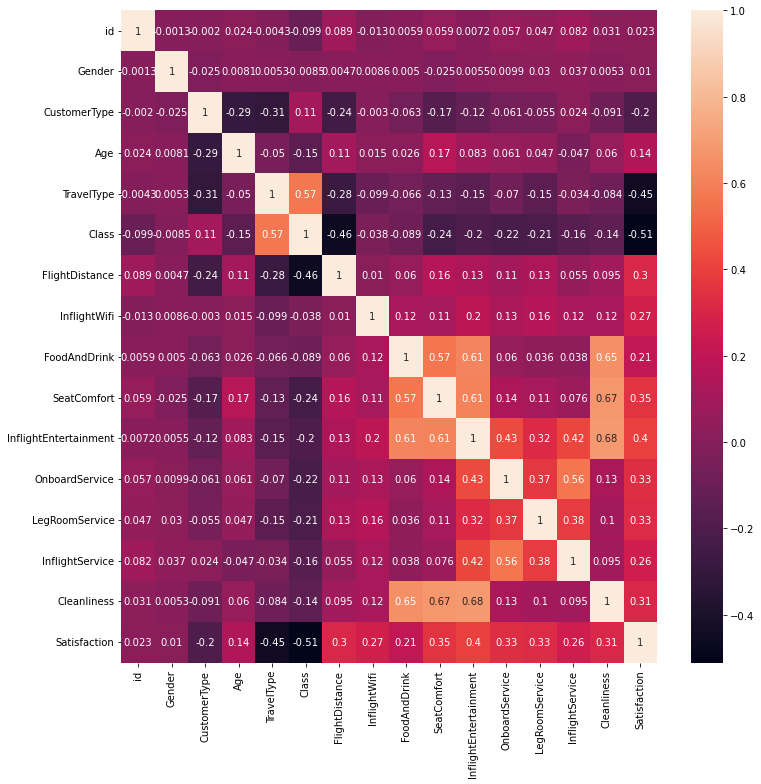

In [18]:
#Correlation Matrix for variables
plt.figure(figsize=(12,12))
ax = sns.heatmap(cleaned_satisfaction_df.corr(), annot=True)

It seems that most of the data is not highly correlated with each other, as most of the correlation numbers are below 0.4. However, we can see that FoodAndDrink, SeatComfort, and InflightEntertainment seem to have higher correlation levels than the other categories with cleanliness and each other. This may suggest that these categories may be more important in forming customer satisfaction, but that remains to be tested in our analysis. So when we test in our analyses, we may focus on these categories first to see if they have a significant impact on satisfaction outcomes.

## Ratings based on gender 

There is no apparent difference in ratings when separated by gender. This is somewhat expected.

In [19]:
# Female: 0, Male: 1
gender_df = cleaned_satisfaction_df.groupby(['Gender']).mean()

In [20]:
# Reference: https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/

X = ['InflightWifi', 'FoodAndDrink', 'SeatComfort',
       'InflightEntertainment', 'OnboardService', 'LegRoomService',
       'InflightService', 'Cleanliness', 'Satisfaction']

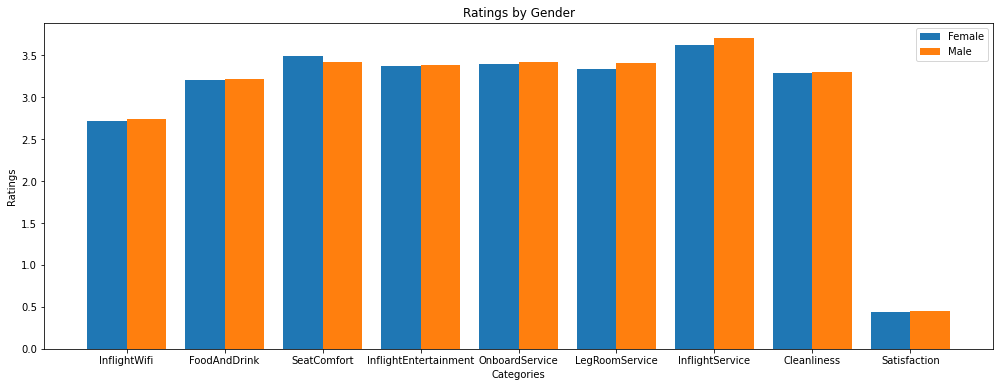

In [21]:
Female = gender_df.iloc[0, 6:]
Male = gender_df.iloc[1, 6:]
  
X_axis = np.arange(len(X))

plt.figure(figsize=(17,6))

plt.bar(X_axis - 0.2, Female, 0.4, label = 'Female')
plt.bar(X_axis + 0.2, Male, 0.4, label = 'Male')
  
plt.xticks(X_axis, X)
plt.xlabel("Categories")
plt.ylabel("Ratings")
plt.title("Ratings by Gender")
plt.legend()
plt.show()

## Ratings based on Customer Type

Overall, loyal customers have higher average ratings than disloyal customers. Among categories, FoodAndDrink has the biggest difference and legRoomService has the smallest difference.

In [22]:
#Loyal: 0, Disloyal: 1

customer_means = cleaned_satisfaction_df.groupby(['CustomerType']).mean()

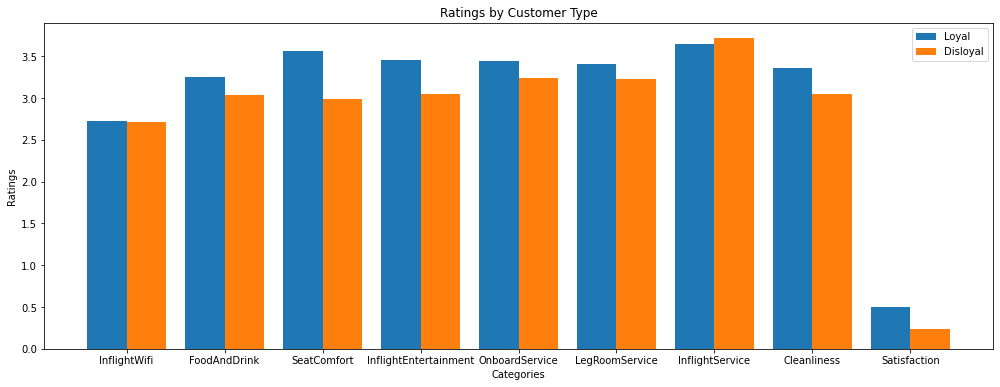

In [23]:
Loyal = customer_means.iloc[0, 6:]
Disloyal = customer_means.iloc[1, 6:]
  
X_axis = np.arange(len(X))

plt.figure(figsize=(17,6))

plt.bar(X_axis - 0.2, Loyal, 0.4, label = 'Loyal')
plt.bar(X_axis + 0.2, Disloyal, 0.4, label = 'Disloyal')
  
plt.xticks(X_axis, X)
plt.xlabel("Categories")
plt.ylabel("Ratings")
plt.title("Ratings by Customer Type")
plt.legend()
plt.show()

## Ratings based on Travel Type

Overall, passengers on business travel have higher average ratings than passengers on personal travel. Among categories, InflightService and FoodAndDrink have the biggest differences and legRoomService has the smallest difference.

In [24]:
# Business travel: 0, Personal travel: 1

travel_means = cleaned_satisfaction_df.groupby(['TravelType']).mean()

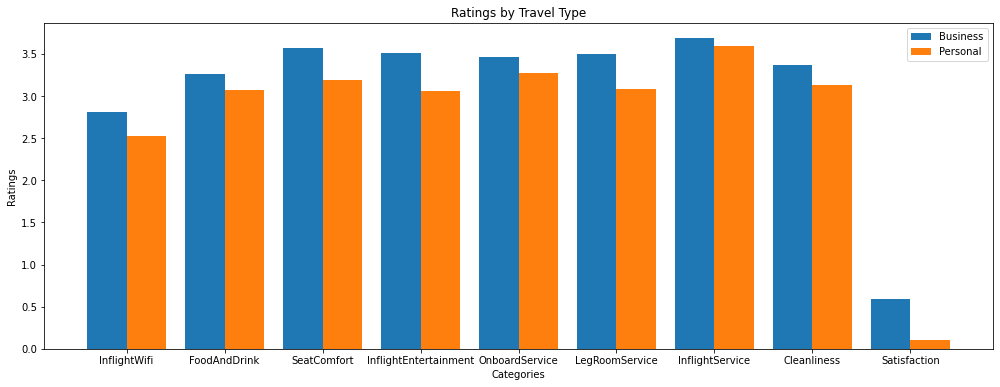

In [25]:
Business = travel_means.iloc[0, 6:]
Personal = travel_means.iloc[1, 6:]
  
X_axis = np.arange(len(X))

plt.figure(figsize=(17,6))

plt.bar(X_axis - 0.2, Business, 0.4, label = 'Business')
plt.bar(X_axis + 0.2, Personal, 0.4, label = 'Personal')
  
plt.xticks(X_axis, X)
plt.xlabel("Categories")
plt.ylabel("Ratings")
plt.title("Ratings by Travel Type")
plt.legend()
plt.show()

## Ratings based on Class

Overall, business class passengers have higher average ratings than economy class passengers. Note that class 'others' was not included in the bar chart. Among categories, InflightService, SeatComfort FoodAndDrink have the biggest differences and legRoomService has the smallest difference.

In [26]:
# Business: 0, Eco: 1

class_means = cleaned_satisfaction_df.groupby(['Class']).mean()

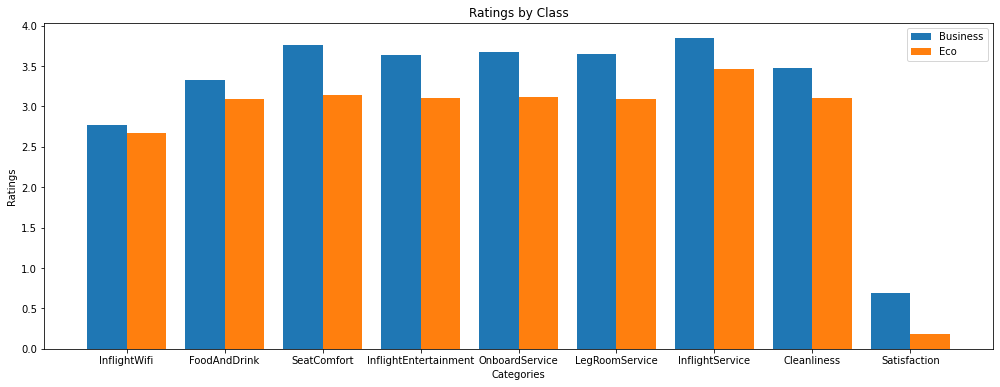

In [27]:
Business = class_means.iloc[0, 6:]
Eco = class_means.iloc[1, 6:]
  
X_axis = np.arange(len(X))

plt.figure(figsize=(17,6))

plt.bar(X_axis - 0.2, Business, 0.4, label = 'Business')
plt.bar(X_axis + 0.2, Eco, 0.4, label = 'Eco')
  
plt.xticks(X_axis, X)
plt.xlabel("Categories")
plt.ylabel("Ratings")
plt.title("Ratings by Class")
plt.legend()
plt.show()

## Ratings based on Overall Satisfaction

In [28]:
# Neutral or Dissatisfied: 0, Satisfied: 1
satisfaction_df = cleaned_satisfaction_df.groupby(['Satisfaction']).mean()
satisfaction_df

,id,Gender,CustomerType,Age,TravelType,Class,FlightDistance,InflightWifi,FoodAndDrink,SeatComfort,InflightEntertainment,OnboardService,LegRoomService,InflightService,Cleanliness
Satisfaction,,,,,,,,,,,,,,,
0,64633.973436,0.489357,0.259821,37.492495,0.482444,0.714723,946.056266,2.399162,2.961600,3.039058,2.894832,3.022337,2.988841,3.386519,2.936332
1,66405.879808,0.499687,0.102730,41.831917,0.068664,0.201501,1566.241078,3.130474,3.512424,3.977259,3.966860,3.884255,3.847827,3.997152,3.744818


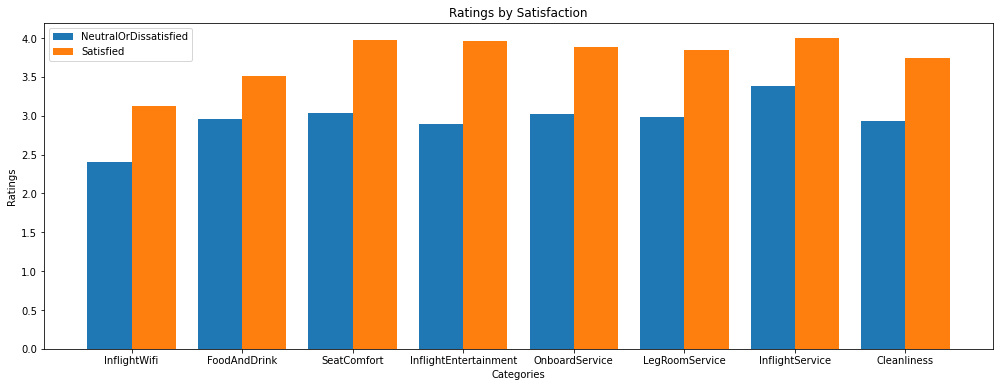

In [29]:
X_satisfaction = ['InflightWifi', 'FoodAndDrink', 'SeatComfort',
       'InflightEntertainment', 'OnboardService', 'LegRoomService',
       'InflightService', 'Cleanliness']

NeutralOrDissatisfied = satisfaction_df.iloc[0, 7:]
Satisfied = satisfaction_df.iloc[1, 7:]
  
X_axis = np.arange(len(X_satisfaction))

plt.figure(figsize=(17,6))

plt.bar(X_axis - 0.2, NeutralOrDissatisfied, 0.4, label = 'NeutralOrDissatisfied')
plt.bar(X_axis + 0.2, Satisfied, 0.4, label = 'Satisfied')
  
plt.xticks(X_axis, X_satisfaction)
plt.xlabel("Categories")
plt.ylabel("Ratings")
plt.title("Ratings by Satisfaction")
plt.legend()
plt.show()

In [30]:
print("Difference in Ratings (Satisfied - NeutralOrDissatisfied)")

satisfaction_diff = Satisfied - NeutralOrDissatisfied
satisfaction_diff.sort_values(ascending=False)

Difference in Ratings (Satisfied - NeutralOrDissatisfied)


InflightEntertainment    1.072029
SeatComfort              0.938201
OnboardService           0.861917
LegRoomService           0.858986
Cleanliness              0.808487
InflightWifi             0.731312
InflightService          0.610633
FoodAndDrink             0.550825
dtype: float64

Among customers whose overall satisfaction was "satisfied" vs "neutral or dissatisfied", each category had differences in ratings as printed above. From this, we can infer that InflightEntertainment, OnboardService, LegRoomService have the most impact in determining passengers' satisfaction.

# Data Analysis:

Differences in average ratings for different kinds of customers and Logistic Regression 

## Hypothesis Testing on Different kinds of Customers

We used hypothesis testing to see if the differences in average ratings for different categories are significantly different between two types of customers. First, business vs economy class travels, then loyal and disloyal customers, and finally between customers travelling for personal vs business reasons. 

$H_0: \mu_1 - \mu_2 = 0$

$H_a: \mu_1 - \mu_2 > 0$

## Hypothesis Test Conclusions

None of these service categories received significantly different average ratings between any two categories of customer that we investigated (at the 95% confidence level). Below are the p values:

**Ratings by Class**
p values (calculated from t-scores): 

<ul>
    <li> InflightWifi :  0.90 </li>
    <li> FoodAndDrink :  0.80 </li>
    <li> SeatComfort :  0.52 </li>
    <li> InflightEntertainment :  0.58 </li>
    <li> OnboardService :  0.55 </li>
    <li> LegRoomService :  0.56 </li>
    <li> InflightService :  0.65 </li> 
    <li> Cleanliness :  0.70 </li>
</ul>

**Ratings by Customer Type**
p values (calculated from t-scores)

<ul>
    <li> InflightWifi :  0.99 </li>
    <li> FoodAndDrink :  0.83 </li>
    <li> SeatComfort :  0.56 </li>
    <li> InflightEntertainment :  0.68 </li>
    <li> OnboardService :  0.83 </li>
    <li> LegRoomService :  0.84 </li>
    <li> InflightService :  0.93 </li>
    <li> Cleanliness :  0.76 </li>
</ul>
    
**Ratings by Travel Type**
p values (calculated from t-scores)

<ul>
    <li> InflightWifi :  0.72 </li>
    <li> FoodAndDrink :  0.84 </li>
    <li> SeatComfort :  0.70 </li>
    <li> InflightEntertainment :  0.65 </li>
    <li> OnboardService :  0.83 </li>
    <li> LegRoomService :  0.65 </li>
    <li> InflightService :  0.92 </li>
    <li> Cleanliness :  0.80 </li>
</ul>

In [31]:
#function for calculating t scores
def t_scores(arr_1, arr_2, list_vars):
    n1 = len(arr_1)
    n2 = len(arr_2)
    for s in list_vars:
        std_1 = np.std(arr_1[s])
        std_2 = np.std(arr_2[s])
        t_score = (np.mean(arr_1[s]) - np.mean(arr_2[s]))/((std_1**2/n1) + (std_2**2/2))**0.5
        print(s, ": ", round(t_score, 2))

In [32]:
#list of variables we are calculating t scores for 
list_vars = ['InflightWifi', 'FoodAndDrink', 'SeatComfort',
       'InflightEntertainment', 'OnboardService', 'LegRoomService',
       'InflightService', 'Cleanliness']

## Ratings based on Class

Overall, there is not a significant difference in the averages of ratings for any category betweeen business and economy class at the 95% confidence level. 

In [33]:
bus = cleaned_satisfaction_df[cleaned_satisfaction_df["Class"] == 0][list_vars]
eco = cleaned_satisfaction_df[cleaned_satisfaction_df["Class"] == 1][list_vars]

print("degrees of freedom: ", len(bus) - 1 + len(eco) - 1)

degrees of freedom:  96408


In [34]:
t_scores(bus, eco, list_vars)

InflightWifi :  0.12
FoodAndDrink :  0.25
SeatComfort :  0.65
InflightEntertainment :  0.56
OnboardService :  0.6
LegRoomService :  0.59
InflightService :  0.45
Cleanliness :  0.39


## Ratings based on Customer Type

Overall, there is not a significant difference in the averages of ratings for any category between disloyal and loyal customers at the 95% confidence level.

In [35]:
loyal = cleaned_satisfaction_df[cleaned_satisfaction_df["CustomerType"]==0][list_vars]
disloyal = cleaned_satisfaction_df[cleaned_satisfaction_df["CustomerType"]==1][list_vars]

print("degrees of freedom: ", len(loyal) - 1 + len(disloyal) - 1)

degrees of freedom:  96408


In [36]:
t_scores(loyal, disloyal, list_vars)

InflightWifi :  0.01
FoodAndDrink :  0.22
SeatComfort :  0.58
InflightEntertainment :  0.41
OnboardService :  0.22
LegRoomService :  0.2
InflightService :  -0.09
Cleanliness :  0.31


## Ratings based on Travel Type

There is no significant difference in the averages of ratings for any category between business and personal travel customers at the 95% confidence level.

In [37]:
bustrav = cleaned_satisfaction_df[cleaned_satisfaction_df["TravelType"]==0][list_vars]
perstrav = cleaned_satisfaction_df[cleaned_satisfaction_df["TravelType"]==1][list_vars]

print("degrees of freedom: ", len(bustrav) - 1 + len(perstrav) - 1)

degrees of freedom:  96408


In [38]:
t_scores(bustrav, perstrav, list_vars)

InflightWifi :  0.36
FoodAndDrink :  0.2
SeatComfort :  0.39
InflightEntertainment :  0.46
OnboardService :  0.21
LegRoomService :  0.45
InflightService :  0.1
Cleanliness :  0.25


TODO: write one summary for hypothesis testing & t-tests part of data analysis; add some visualizaions

## Logistic Regression

In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def run_logistic_regression(features, train, test, target):
    X = train[features]
    Y = train[target]
    model = LogisticRegression().fit(train[features], train[target])
    y_true_train = train[target]
    y_true_test = test[target]
    y_pred_train = model.predict(train[features])
    y_pred_test = model.predict(test[features])
    
    print("Variable(s): ", features)
    print("Coefficient(s): ", model.coef_)
    print("Intercept: ", model.intercept_)
    print("")
    print("Train Accuracy: ", accuracy_score(y_true_train,y_pred_train))
    print("Train Precision: ", precision_score(y_true_train,y_pred_train))
    print("Train Recall: ", recall_score(y_true_train,y_pred_train))
    print("Train f1: ", f1_score(y_true_train,y_pred_train))
    print("")
    print("Test Accuracy: ", accuracy_score(y_true_test,y_pred_test))
    print("Test Precision: ", precision_score(y_true_test,y_pred_test))
    print("Test Recall: ", recall_score(y_true_test,y_pred_test))
    print("Test f1: ", f1_score(y_true_test,y_pred_test))
    
    if (len(features) > 1):
        plt.figure(0, figsize=(18,5))
        
        # bar graph
        plt.subplot(1,2,1)

        df = pd.DataFrame()
        df['Features'] = features
        df['Coefficients'] = model.coef_[0]
        
        plot = sns.barplot(data=df, x='Features', y='Coefficients', hue='Features', dodge=False)
        plot.legend(fontsize = 8)
        plt.xticks(rotation=30)
        
        # scatter plot
        plt.subplot(1,2,2)

        test['avg_rating'] = test[features].mean(axis=1)
        sns.scatterplot(data=test, x='avg_rating',y=target, hue=y_pred_test)
        
        plt.show()

    
#     b = model.intercept_[0]
# #     w1, w2 = model.coef_.T
#     # Calculate the intercept and gradient of the decision boundary.
#     c = -b/model.coef_
#     m = model.coef_
# #     m = -w1/w2

#     # Plot the data and the classification with the decision boundary.
#     xmin, xmax = -1, 2
#     ymin, ymax = -1, 2.5
#     xd = np.array([xmin, xmax])
#     yd = m*xd + c
#     plt.plot(xd, yd.T, 'k', lw=1, ls='--')
#     print(yd.shape)
#     plt.fill_between(xd, yd.flatten(), ymin, color='tab:blue', alpha=0.2)
#     plt.fill_between(xd, yd.flatten(), ymax, color='tab:orange', alpha=0.2)

#     plt.scatter(*X[Y==0][0:10].T)
#     plt.scatter(*X[Y==1][0:10].T)
#     plt.xlim(xmin, xmax)
#     plt.ylim(ymin, ymax)
#     plt.ylabel(r'$x_2$')
#     plt.xlabel(r'$x_1$')

#     plt.show()

#     df = pd.DataFrame()
#     df['Features'] = features
#     df['Coefficients'] = model.coef_[0]
#     if len(model.coef_[0]) > 1:
#         plot = sns.barplot(data=df, x='Features', y='Coefficients', hue='Features', dodge=False)
#         plot.legend(fontsize = 6)
#         plt.xticks(rotation=30)
#         plt.show()

#     plt.figure(0, figsize=(15,7))
#     pos = 1
#     for f in features:
#         plt.subplot(2,4, pos)
#         pos += 1
#         sns.scatterplot(data=test, x=f,y=target, hue=y_pred_test)
#     plt.show()
    
#     if (len(features) > 1):
#         test['avg_rating'] = test[features].mean(axis=1)
#         sns.scatterplot(data=test, x='avg_rating',y=target, hue=y_pred_test)
#         plt.show()

## Does Inflight Entertainment have a higher effect on customer satisfaction than Inflight Wifi?

After training the logistic regression models and printing the coefficients, we find that the effects of inflight entertainment are similar to that of inflight wifi. Inflight entertainment seems to have a slightly higher effect than inflight wifi though the difference is slim. Specifically, flights with better inflight entertainment were $e^{0.70}$ times the odds of being satisfied than not and flights with better inflight wifi were $e^{0.43}$ times the odds of being satisfied than not. From this, we can say that inflight entertainment does have a higher effect on customer satisfaction than inflight wifi.

In [115]:
all_train, all_test = train_test_split(cleaned_satisfaction_df, test_size = 0.2)

run_logistic_regression(['InflightEntertainment'], all_train, all_test, 'Satisfaction')
print()
run_logistic_regression(['InflightWifi'], all_train, all_test, 'Satisfaction')

Variable(s):  ['InflightEntertainment']
Coefficient(s):  [[0.69869201]]
Intercept:  [-2.63267575]

Train Accuracy:  0.7045430971890883
Train Precision:  0.6428015185437554
Train Recall:  0.7650909512223381
Train f1:  0.6986352094794752

Test Accuracy:  0.7004460118244995
Test Precision:  0.6403585696190198
Test Recall:  0.7591544414924338
Test f1:  0.6947145877378436

Variable(s):  ['InflightWifi']
Coefficient(s):  [[0.43591544]]
Intercept:  [-1.41603756]

Train Accuracy:  0.7020277979462711
Train Precision:  0.7490075940628236
Train Recall:  0.5028096396709535
Train f1:  0.6016984402079721

Test Accuracy:  0.7017944196660098
Test Precision:  0.7504738928140617
Test Recall:  0.5030611066189211
Test f1:  0.6023513139695713


## How much influence do customer type, travel type, and class have over the overall satisfaction?

CustomerType - 0: Loyal, 1: Disloyal <br>
Travel Type - 0: Business travel, 1: Personal travel <br>
Class - 0: Business, 1: Eco <br>

When customer type, travel type, and class are used independently to predict the overall satisfaction, we have the following results:
- disloyal customers have $e^{-1.12}$ times the odds of being satisfied than loyal customers
- personal travelers have $e^{-2.54}$ times the odds of being satisfied than business travelers
- Economy class customers have $e^{-2.29}$ times the odds of being satisfied than business class customers

From this, we can say that class tends to have the biggest difference in overall satisfaction, then travel type, then customer type.

In [116]:
run_logistic_regression(['CustomerType'], all_train, all_test, 'Satisfaction')

Variable(s):  ['CustomerType']
Coefficient(s):  [[-1.13231634]]
Intercept:  [-0.01528359]

Train Accuracy:  0.5523804584586661
Train Precision:  0.0
Train Recall:  0.0
Train f1:  0.0

Test Accuracy:  0.5510320506171559
Test Precision:  0.0
Test Recall:  0.0
Test f1:  0.0


C:\Users\Seoyeon Jeong\anaconda3\envs\info2950\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seoyeon Jeong\anaconda3\envs\info2950\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
run_logistic_regression(['TravelType'], all_train, all_test, 'Satisfaction')

Variable(s):  ['TravelType']
Coefficient(s):  [[-2.52739261]]
Intercept:  [0.37511664]

Train Accuracy:  0.6827870552847215
Train Precision:  0.5927414893224653
Train Recall:  0.9310045185957595
Train f1:  0.7243267605633803

Test Accuracy:  0.6863395913287004
Test Precision:  0.5963512814831228
Test Recall:  0.9326556543837357
Test f1:  0.7275184717967199


In [118]:
run_logistic_regression(['Class'], all_train, all_test, 'Satisfaction')

Variable(s):  ['Class']
Coefficient(s):  [[-2.2978198]]
Intercept:  [0.82134477]

Train Accuracy:  0.7526060574629188
Train Precision:  0.6945795428773026
Train Recall:  0.7983721469122929
Train f1:  0.7428679235112591

Test Accuracy:  0.7508038585209004
Test Precision:  0.6929473051492687
Test Recall:  0.7990065842670672
Test f1:  0.7422071999570793


TODO: Decision boundaries

## What features have the largest influence over the overall satisfaction for all customers?

When only the inflight services are considered without the customer type, travel type, and class to predict ths satisfaction, Seatcomfort (0.74717157) has the highest coefficient followed by Cleaness(0.7093937). The rest of the list goes as OnboardService (0.57865559), LegRoomService (0.50969703), InflightService (0.37866948), InflightWifi (-0.29618218), InflightEntertainment (0.29236722), FoodAndDrink (0.2236989). We can observe that the services that most differed by customer type, travel type, and class tend to have smaller coefficients when assessed for overall satisfactions of all groups of customers.

TODO: we prob need to update the coefficients!!

Variable(s):  ['InflightWifi', 'FoodAndDrink', 'SeatComfort', 'InflightEntertainment', 'OnboardService', 'LegRoomService', 'InflightService', 'Cleanliness']
Coefficient(s):  [[ 0.38268246 -0.12096757  0.44647255  0.14357786  0.36165461  0.35608862
   0.07273391  0.18109156]]
Intercept:  [-6.31083273]

Train Accuracy:  0.7522430245825122
Train Precision:  0.7287024123913237
Train Recall:  0.7113312478275982
Train f1:  0.7199120556980579

Test Accuracy:  0.7532413650036304
Test Precision:  0.7351344831745266
Test Recall:  0.704054522351854
Test f1:  0.7192589096058531


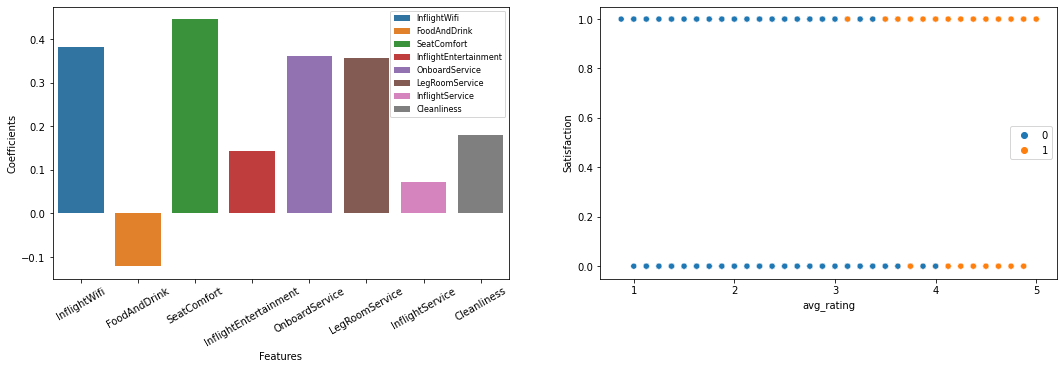

In [119]:
sat_features = ['InflightWifi', 'FoodAndDrink', 'SeatComfort','InflightEntertainment', 
                'OnboardService', 'LegRoomService','InflightService', 'Cleanliness'] 

run_logistic_regression(sat_features, all_train, all_test, 'Satisfaction')

## What features have the largest influence over the overall satisfaction by customer type?

Again, when the models were trained seperately for loyal vs. disloyal customers, the overall trends of the coefficients were similar to that for all customers. However, as we've witnessed from the histogram earlier, we can see that the coefficients vary the most for services like InflightEntertainment.


-----Log Regression of Customer Type: Loyal-----

Variable(s):  ['InflightWifi', 'FoodAndDrink', 'SeatComfort', 'InflightEntertainment', 'OnboardService', 'LegRoomService', 'InflightService', 'Cleanliness']
Coefficient(s):  [[ 0.27147373 -0.06659369  0.490362    0.24059109  0.32505645  0.43858948
  -0.03749618  0.21738026]]
Intercept:  [-6.38980713]

Train Accuracy:  0.7673518355594657
Train Precision:  0.7555287494973865
Train Recall:  0.7862683876782438
Train f1:  0.7705921322439194

Test Accuracy:  0.7680593767995393
Test Precision:  0.7502160760587727
Test Recall:  0.7913519145610837
Test f1:  0.7702351524370921


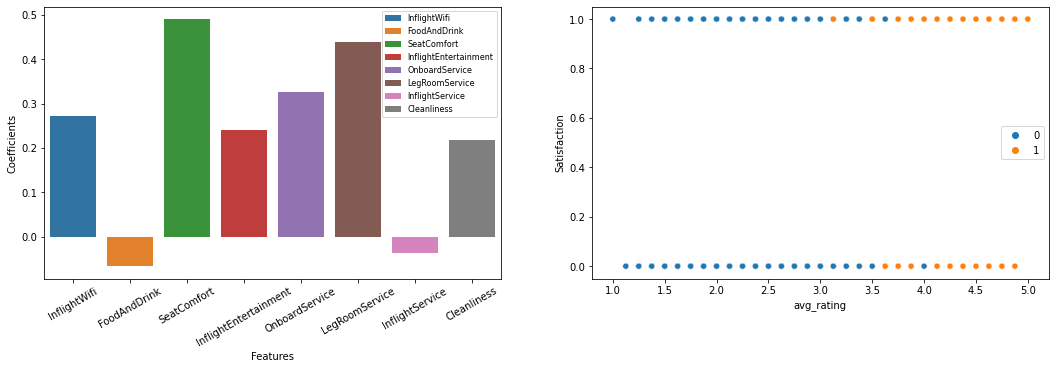


-----Log Regression of Customer Type: Disloyal-----
Variable(s):  ['InflightWifi', 'FoodAndDrink', 'SeatComfort', 'InflightEntertainment', 'OnboardService', 'LegRoomService', 'InflightService', 'Cleanliness']
Coefficient(s):  [[ 0.92232852  0.04395471  0.03367739  0.13934422  0.31733467  0.07713084
   0.33249727 -0.1799419 ]]
Intercept:  [-6.70799587]

Train Accuracy:  0.8720229947987955
Train Precision:  0.8470103092783505
Train Recall:  0.578103011539544
Train f1:  0.687186349949816

Test Accuracy:  0.8686371100164204
Test Precision:  0.8276422764227642
Test Recall:  0.5764439411098528
Test f1:  0.6795727636849133


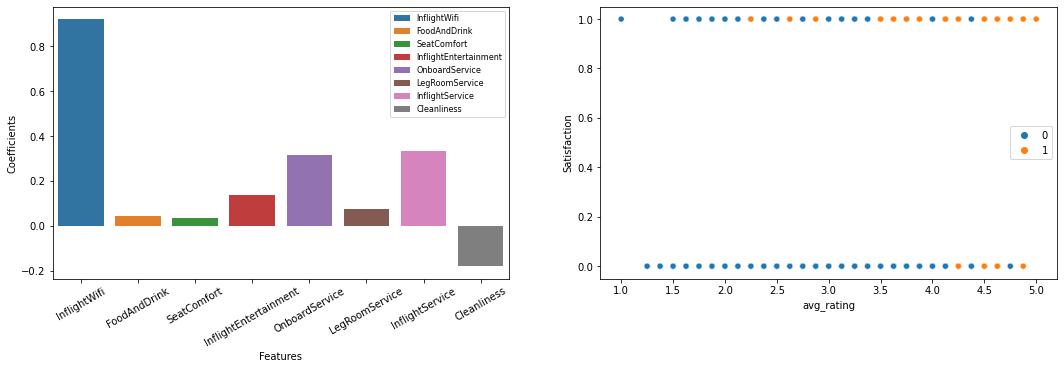

In [120]:
customer_loyal_df = cleaned_satisfaction_df[cleaned_satisfaction_df['CustomerType'] == 0]
customer_loyal_train, customer_loyal_test = train_test_split(customer_loyal_df, test_size = 0.2)

print("-----Log Regression of Customer Type: Loyal-----\n")
run_logistic_regression(sat_features, customer_loyal_train, customer_loyal_test, 'Satisfaction')

customer_disloyal_df = cleaned_satisfaction_df[(cleaned_satisfaction_df['CustomerType'] == 1)]
customer_disloyal_train, customer_disloyal_test = train_test_split(customer_disloyal_df, test_size = 0.2)

print("\n-----Log Regression of Customer Type: Disloyal-----")
run_logistic_regression(sat_features, customer_disloyal_train, customer_disloyal_test, 'Satisfaction')

## What features have the largest influence over the overall satisfaction by Travel type?

As we can see in our model's predictions and coefficients, when a passenger is travelling for business needs, they case most about seat comfort and onboard service. However, when travelling for personal reasons, inflight wifi seems to be the most important criteria by far.

-----Log Regression of Travel Type: Business-----

Variable(s):  ['InflightWifi', 'FoodAndDrink', 'SeatComfort', 'InflightEntertainment', 'OnboardService', 'LegRoomService', 'InflightService', 'Cleanliness']
Coefficient(s):  [[ 0.28332072 -0.06725066  0.54557748  0.04857099  0.52128851  0.315447
   0.19089868  0.33010916]]
Intercept:  [-6.9004718]

Train Accuracy:  0.7864863867778351
Train Precision:  0.8021810058493284
Train Recall:  0.8492345033607169
Train f1:  0.8250374110071497

Test Accuracy:  0.7866155094812957
Test Precision:  0.8052482937161685
Test Recall:  0.8469059405940594
Test f1:  0.8255519363011219


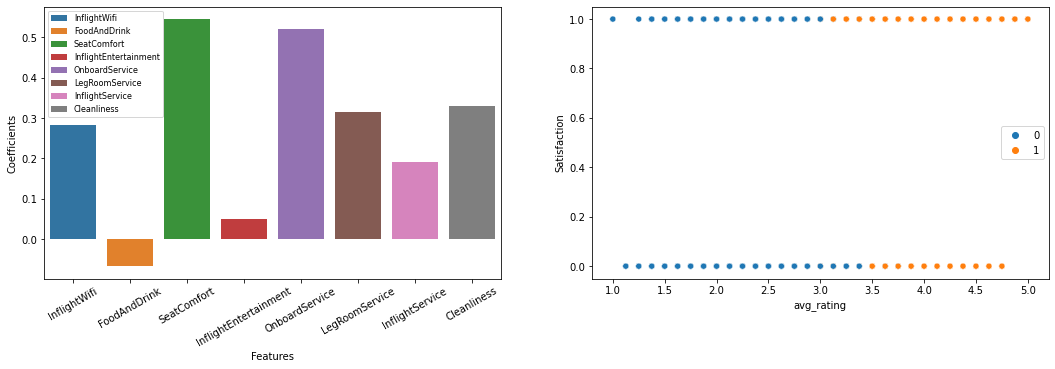


-----Log Regression of Travel Type: Personal-----

Variable(s):  ['InflightWifi', 'FoodAndDrink', 'SeatComfort', 'InflightEntertainment', 'OnboardService', 'LegRoomService', 'InflightService', 'Cleanliness']
Coefficient(s):  [[ 1.03693028e+00  5.15585273e-03  3.49306332e-02 -4.43087968e-02
   6.50629996e-04 -4.03227155e-02  1.57641135e-02 -4.46620847e-03]]
Intercept:  [-5.17701611]

Train Accuracy:  0.8988916041193926
Train Precision:  1.0
Train Recall:  0.02524190155658393
Train f1:  0.04924086992203529

Test Accuracy:  0.8999825449467621
Test Precision:  1.0
Test Recall:  0.025510204081632654
Test f1:  0.04975124378109453


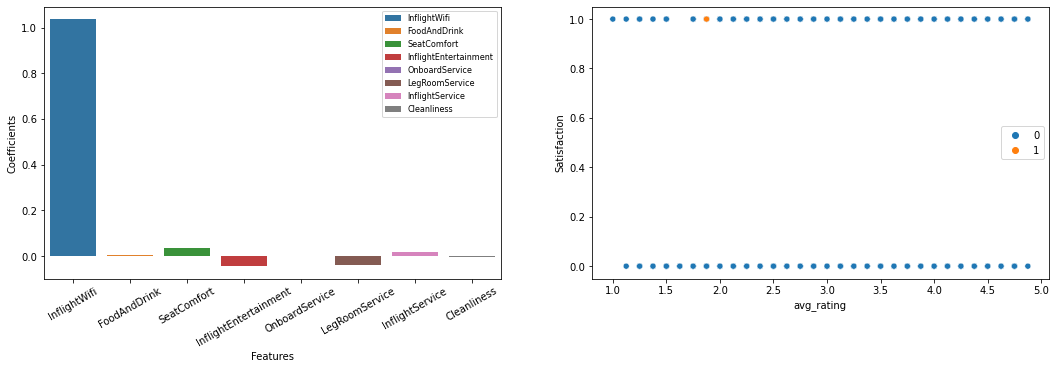

In [121]:
business_travel_df = cleaned_satisfaction_df[(cleaned_satisfaction_df['TravelType'] == 0)]
business_travel_train, business_travel_test = train_test_split(business_travel_df, test_size = 0.2)

print("-----Log Regression of Travel Type: Business-----\n")
run_logistic_regression(sat_features, business_travel_train, business_travel_test, 'Satisfaction')

personal_travel_df = cleaned_satisfaction_df[(cleaned_satisfaction_df['TravelType'] == 1)]
personal_travel_train, personal_travel_test = train_test_split(personal_travel_df, test_size = 0.2)

print("\n-----Log Regression of Travel Type: Personal-----\n")
run_logistic_regression(sat_features, personal_travel_train, personal_travel_test, 'Satisfaction')

## What features have the largest influence over the overall satisfaction by Class?

When travelling in business class, the most important feature seems to be seat comfort while for economy, the most important would be inflight wifi once again.

-----Log Regression of Class Type: Business-----

Variable(s):  ['InflightWifi', 'FoodAndDrink', 'SeatComfort', 'InflightEntertainment', 'OnboardService', 'LegRoomService', 'InflightService', 'Cleanliness']
Coefficient(s):  [[ 0.1300485  -0.01822729  0.53615022  0.0331702   0.45855078  0.46796265
   0.11656902  0.41214629]]
Intercept:  [-6.53302714]

Train Accuracy:  0.8128712372898419
Train Precision:  0.8398087876322213
Train Recall:  0.9013864124304065
Train f1:  0.8695087491443916

Test Accuracy:  0.8259337561663143
Test Precision:  0.8535963499731616
Test Recall:  0.9088441205886555
Test f1:  0.8803543007404332


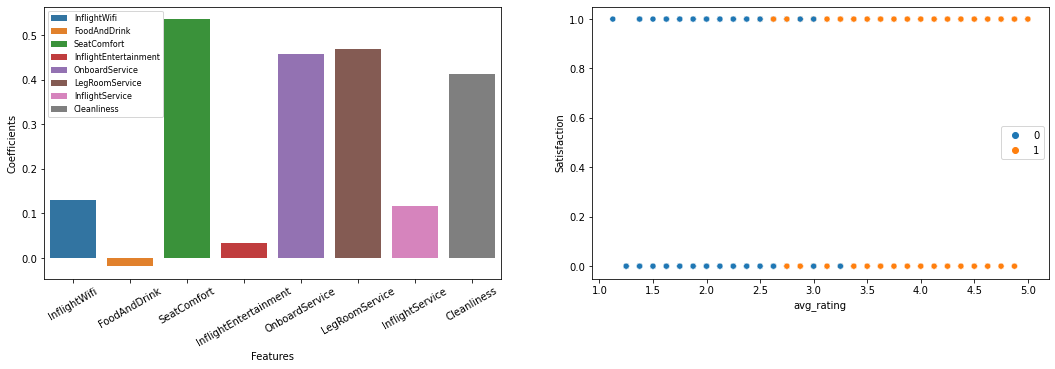


-----Log Regression of Class Type: Economy-----

Variable(s):  ['InflightWifi', 'FoodAndDrink', 'SeatComfort', 'InflightEntertainment', 'OnboardService', 'LegRoomService', 'InflightService', 'Cleanliness']
Coefficient(s):  [[ 1.2263221  -0.04508792  0.02993794  0.21534987  0.08894476  0.00222539
  -0.10021216 -0.01475599]]
Intercept:  [-5.9120165]

Train Accuracy:  0.8869130388276821
Train Precision:  0.9642492339121552
Train Recall:  0.40713053479010924
Train f1:  0.5725260285050036

Test Accuracy:  0.887688522836667
Test Precision:  0.9664429530201343
Test Recall:  0.41260744985673353
Test f1:  0.5783132530120483


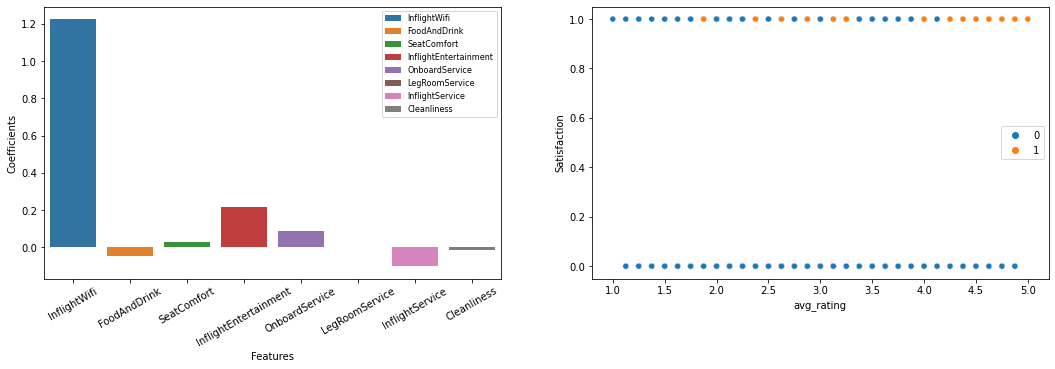

In [122]:
# Business: 0, Eco: 1
business_class_df = cleaned_satisfaction_df[(cleaned_satisfaction_df['Class'] == 0)]
business_class_train, business_class_test = train_test_split(business_class_df, test_size = 0.2)

print("-----Log Regression of Class Type: Business-----\n")
run_logistic_regression(sat_features, business_class_train, business_class_test, 'Satisfaction')

economy_class_df = cleaned_satisfaction_df[(cleaned_satisfaction_df['Class'] == 1)]
economy_class_train, economy_class_test = train_test_split(economy_class_df, test_size = 0.2)

print("\n-----Log Regression of Class Type: Economy-----\n")
run_logistic_regression(sat_features, economy_class_train, economy_class_test, 'Satisfaction')

TODO: add one summary for log regression part of data analysis & add visualizations

# Conclusion

To improve the satisfaction of all types of customers, the airline should focus on enhancing services like Seatcomfort and inflight wifi. To improve the satisfaction specific to disloyal customers, relatively to loyal customers, the airline should focus on enhancing services like Inflightentertainment. Regarding the satisfaction based on business class travelers, airlines should focus on seat comfort and improving inflight wifi for economy class travelers. The results for those traveling with business needs and personal needs were similar to the business class and economy class travelers.

# Limitations

## Limitations of Study

A main limitation of our study is that our data is only from one airline and is therefore less generalizable, but our project could help that airline see what customers value. The classification of customers also falls into only two categories: “satisfied” and “neutral or dissatisfied,” which are not very specifically reflective of someone’s experience. 

We also do not know who we are sampling from due to customer confidentiality. We do not know what kind of flights there were or which airline it was. If we could possibly combine this data set with another, we might have chosen a data set where we know which airlines the data was coming from or one that has takeoff and landing desintations for the purpose of better business applications from our study. 

## Biases in Data

Satisfaction is not an objective metric. For example, if two people feel the same absolute satisfaction about something, it is still possible that they rate that attribute of their flight differently. Additionally, something that is extremely displeasing to one passenger could be just a minor inconvenience to another, so expectations and mood also play into this survey. 

There are some more concrete biases that could influence the ratings as well. For example, if someone usually flies economy class and flies business class because someone else pays for them, then they might rate services higher just because they are used to different ones.

We also find that there are a lot more observations for certain customers than others. For example, there were many more loyal customers than disloyal ones, and many more business class customers than economy class ones. 

Finally, since the data collection was voluntary, customers with stronger opinions were most likely the ones filling out the survey, which biases the data away from medium-satisfaction customers. 